In [1]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import StandardScaler
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path_train = 'train.csv'
path_test = 'test.csv'

In [3]:
train_df_raw = pd.read_csv(path_train)

In [4]:
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [8]:
draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


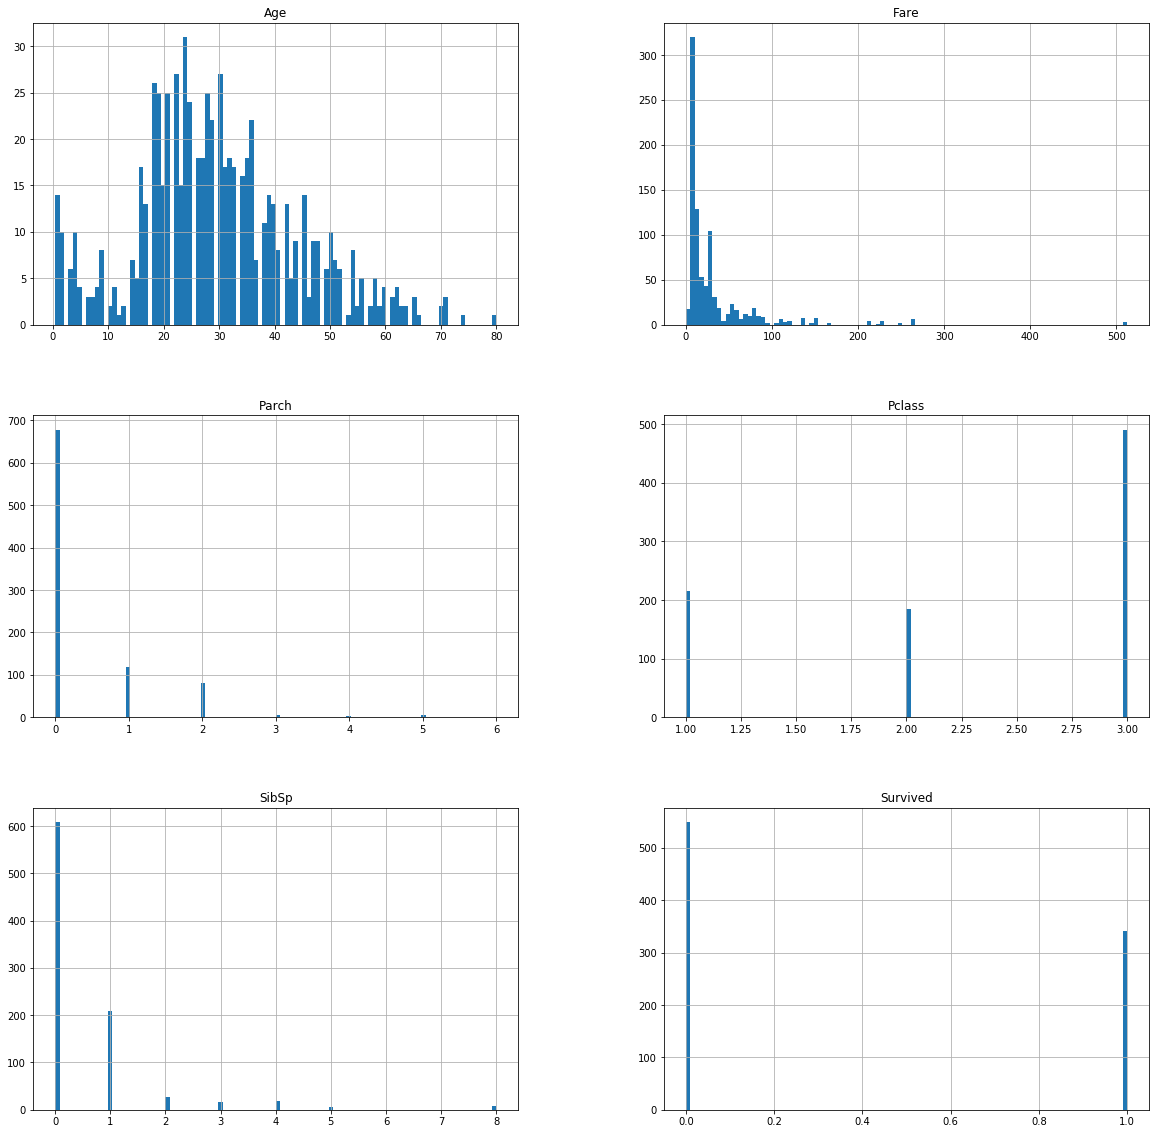

In [86]:
train_df_raw.drop(['PassengerId'], axis=1).hist(bins=100, figsize=(20,20))
plt.show()

In [10]:
processed_df = train_df_raw

In [11]:
# Drop useless columns
processed_df = processed_df.drop(['PassengerId'], axis=1)

In [12]:
processed_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
processed_df['Embarked'].fillna('S', inplace=True)

In [14]:
processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)

In [15]:
processed_df['Age'] = processed_df['Age'].astype(int)

In [16]:
processed_df['Fare'] = processed_df['Fare'].interpolate()

In [17]:
processed_df['Cabin'].fillna('U', inplace=True)

# feature engineering on columns

In [18]:
processed_df['Title'] = pd.Series(
    (name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), 
    index=train_df_raw.index)

In [19]:
processed_df['Title'] = processed_df['Title'].replace(
    [
        'Lady', 
        'the Countess',
        'Countess',
        'Capt', 
        'Col',
        'Don', 
        'Dr', 
        'Major', 
        'Rev', 
        'Sir', 
        'Jonkheer', 
        'Dona'
    ], 'Rare')

In [20]:
processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')

In [21]:
processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')

In [22]:
processed_df['Title'] = processed_df['Title'].map(
    {
        "Mr": 1, 
        "Miss": 2, 
        "Mrs": 3, 
        "Master": 4, 
        "Rare": 5
    })

In [23]:
processed_df['Sex'] = processed_df['Sex'].map(
    {
     'male': 0, 
     'female': 1
    })

In [24]:
processed_df['Embarked'] = processed_df['Embarked'].map(
    {
        'S': 0, 
        'C': 1, 
        'Q': 2
    })

In [25]:
processed_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,U,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1,3
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,U,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0,3
4,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,U,0,1


In [26]:
processed_df['Familly_size'] = processed_df['SibSp'] + processed_df['Parch'] + 1

In [27]:
processed_df.Familly_size.head()

0    2
1    2
2    1
3    2
4    1
Name: Familly_size, dtype: int64

In [28]:
processed_df['IsAlone'] = np.where(processed_df['Familly_size']!=1, 0, 1)

In [29]:
processed_df['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

In [30]:
processed_df['Cabin'] = processed_df['Cabin'].str[:1]

In [31]:
enumerate(set(cab for cab in processed_df['Cabin']))

In [32]:
processed_df['Cabin'] = processed_df['Cabin'].map(
    {cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Cabin']))})

In [33]:
processed_df = processed_df.drop(['Name', 'Ticket'], axis = 1)

In [34]:
processed_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Familly_size,IsAlone
0,0,3,0,22,1,0,7.2500,1,0,1,2,0
1,1,1,1,38,1,0,71.2833,3,1,3,2,0
2,1,3,1,26,0,0,7.9250,1,0,2,1,1
3,1,1,1,35,1,0,53.1000,3,0,3,2,0
4,0,3,0,35,0,0,8.0500,1,0,1,1,1


In [35]:
def preprocess_data(df):
    processed_df = df
    
    # Drop useless columns
    processed_df = processed_df.drop(['PassengerId'], 1)
    
    # Deal with missing values
    processed_df['Embarked'].fillna('S', inplace=True)
    processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)
    processed_df['Age'] = processed_df['Age'].astype(int)
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U', inplace=True)
    
    # feature engineering on columns
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    
    processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    processed_df['Familly_size'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['IsAlone'] = np.where(processed_df['Familly_size']!=1, 0, 1)
    
    #Creation of a deck column corresponding to the letter contained in the cabin value
    processed_df['Cabin'] = processed_df['Cabin'].str[:1]
    processed_df['Cabin'] = processed_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Cabin']))})
    
    processed_df = processed_df.drop(['Name', 'Ticket'], 1)    
    
    return processed_df

In [36]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
predictors = train_df.drop(['Survived'], axis = 1)
target = to_categorical(train_df['Survived'])

In [37]:
target

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [38]:
predictors = preprocess_data(predictors)

In [39]:
sc = StandardScaler()
predictors = pd.DataFrame(
    sc.fit_transform(predictors.values), 
    index=predictors.index, 
    columns=predictors.columns)

In [57]:
predictors.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Familly_size,IsAlone
0,0.827377,-0.737695,-0.580044,0.432793,-0.473674,-0.502445,-0.435853,-0.568837,-0.707550,0.059160,-1.231645
1,-1.566107,1.355574,0.650112,0.432793,-0.473674,0.786845,0.655004,1.005181,1.235215,0.059160,-1.231645
2,0.827377,1.355574,-0.272505,-0.474545,-0.473674,-0.488854,-0.435853,-0.568837,0.263832,-0.560975,0.811922
3,-1.566107,1.355574,0.419458,0.432793,-0.473674,0.420730,0.655004,-0.568837,1.235215,0.059160,-1.231645
4,0.827377,-0.737695,0.419458,-0.474545,-0.473674,-0.486337,-0.435853,-0.568837,-0.707550,-0.560975,0.811922


In [58]:
predictors = predictors.as_matrix()

In [59]:
predictors

array([[ 0.82737724, -0.73769513, -0.58004441, ..., -0.7075504 ,
         0.05915988, -1.2316449 ],
       [-1.56610693,  1.35557354,  0.65011226, ...,  1.2352151 ,
         0.05915988, -1.2316449 ],
       [ 0.82737724,  1.35557354, -0.27250525, ...,  0.26383235,
        -0.56097483,  0.81192233],
       ...,
       [ 0.82737724,  1.35557354, -0.04185087, ...,  0.26383235,
         1.29942929, -1.2316449 ],
       [-1.56610693, -0.73769513, -0.27250525, ..., -0.7075504 ,
        -0.56097483,  0.81192233],
       [ 0.82737724, -0.73769513,  0.18880351, ..., -0.7075504 ,
        -0.56097483,  0.81192233]])

In [60]:
n_cols = predictors.shape[1]

In [61]:
n_cols

11

In [82]:
def build_ann(optimizer='adam', patience=2, n_nodes=10, n_cols=11):
    # Initializing our ANN
    model_1 = Sequential()
    model_1.add(Dense(
        n_nodes,  
        activation='relu', 
        input_shape=(n_cols,)))
    
    model_1.add(Dense(
        n_nodes,  
        activation='relu'))
    
    model_1.add(Dense(
        2,  
        activation='softmax'))
    model_1.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model_1

In [44]:
early_stopping_monitor = EarlyStopping(patience=2)

In [83]:
ann = build_ann(optimizer='adam', patience=2, n_nodes=100, n_cols=n_cols)
# Training the ANN
ann.fit(
    predictors, 
    target, 
#     batch_size=10, 
    epochs=100, 
    validation_split=0.3, 
    callbacks=[early_stopping_monitor])

Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 0s 663us/step - loss: 0.5859 - acc: 0.7127 - val_loss: 0.4559 - val_acc: 0.7799
Epoch 2/100
623/623 [==============================] - 0s 72us/step - loss: 0.4560 - acc: 0.8026 - val_loss: 0.3937 - val_acc: 0.8321
Epoch 3/100
623/623 [==============================] - 0s 83us/step - loss: 0.4317 - acc: 0.8122 - val_loss: 0.3785 - val_acc: 0.8470
Epoch 4/100
623/623 [==============================] - 0s 79us/step - loss: 0.4166 - acc: 0.8315 - val_loss: 0.3829 - val_acc: 0.8545
Epoch 5/100
623/623 [==============================] - 0s 72us/step - loss: 0.4097 - acc: 0.8411 - val_loss: 0.3752 - val_acc: 0.8545
Epoch 6/100
623/623 [==============================] - 0s 79us/step - loss: 0.4052 - acc: 0.8283 - val_loss: 0.3742 - val_acc: 0.8507
Epoch 7/100
623/623 [==============================] - 0s 81us/step - loss: 0.4052 - acc: 0.8266 - val_loss: 0.3781 - val_acc: 0.8470
Epoch 8/100
623

In [46]:
test_df_raw = pd.read_csv(path_test)

In [47]:
test_df_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [48]:
test_df = test_df_raw.copy()

In [49]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
draw_missing_data_table(test_df)

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Survived,0,0.000000
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000


In [50]:
test = preprocess_data(test_df)

In [51]:
test_predictors = pd.DataFrame(
    sc.fit_transform(test.values), 
    index=test.index, 
    columns=test.columns)

In [64]:
test_predictors.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Familly_size,IsAlone
0,0.873482,-0.755929,0.301339,-0.499470,-0.400248,-0.497185,-0.356126,2.243165,-0.756787,-0.553443,0.807573
1,0.873482,1.322876,1.329905,0.616992,-0.400248,-0.512048,-0.356126,-0.677841,1.245346,0.105643,-1.238278
2,-0.315819,-0.755929,2.516711,-0.499470,-0.400248,-0.463874,-0.356126,2.243165,0.244279,-0.553443,0.807573
3,0.873482,-0.755929,-0.252504,-0.499470,-0.400248,-0.482248,-0.356126,-0.677841,1.245346,-0.553443,0.807573
4,0.873482,1.322876,-0.648106,0.616992,0.619896,-0.417269,-0.356126,-0.677841,-0.756787,0.764728,-1.238278


In [65]:
predictions = ann.predict(test_predictors.as_matrix())

In [66]:
predictions

array([[8.57600987e-01, 1.42398998e-01],
       [5.87590933e-01, 4.12409067e-01],
       [7.89495707e-01, 2.10504264e-01],
       [7.75242686e-01, 2.24757329e-01],
       [6.82922840e-01, 3.17077219e-01],
       [8.91276598e-01, 1.08723454e-01],
       [4.19236898e-01, 5.80763042e-01],
       [4.46850061e-01, 5.53149998e-01],
       [1.87105447e-01, 8.12894523e-01],
       [8.78044784e-01, 1.21955223e-01],
       [8.58208776e-01, 1.41791195e-01],
       [7.29281604e-01, 2.70718426e-01],
       [4.35328901e-01, 5.64671099e-01],
       [9.43296373e-01, 5.67036979e-02],
       [8.49926695e-02, 9.15007353e-01],
       [1.86286300e-01, 8.13713729e-01],
       [3.55521202e-01, 6.44478798e-01],
       [8.40612710e-01, 1.59387320e-01],
       [4.16970551e-01, 5.83029449e-01],
       [2.88527608e-01, 7.11472392e-01],
       [8.72432888e-01, 1.27567142e-01],
       [8.43722522e-01, 1.56277537e-01],
       [2.14056864e-01, 7.85943091e-01],
       [6.26444638e-01, 3.73555362e-01],
       [5.279110

In [67]:
predictions = predictions[:, 1]

In [74]:
ann_prediction = predictions > 0.8

In [75]:
ann_prediction = ann_prediction.astype(int)

In [76]:
ann_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
predicted_prob_pd = pd.DataFrame({'Survived':ann_prediction})

In [78]:
test_df['Survived'] = predicted_prob_pd['Survived']

In [79]:
test_df[['PassengerId', 'Survived']].to_csv('submit.csv',index=False)